In [2]:
# Setup for Clipper R kernel

# Make sure both your personal lib and the system libs are visible
.libPaths(c(
  "/mnt/home/bisholea/Rlibs",
  "/opt/gvsu/clipper/2025.05/R/4.4.3/library",
  "/opt/gvsu/clipper/2025.05/spack/apps/linux-rhel9-cascadelake/gcc-13.3.1/r-4.4.3-gz7onk2vbizgd2zxqa6ij47gygl6dsd4/rlib/R/library"
))

# Quick sanity check (optional, just to see)
.libPaths()
"ggplot2" %in% rownames(installed.packages())

# Load the packages you already have
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(fgsea)
library(cowplot)


[1] "/mnt/home/bisholea/Rlibs"                                                                                                       
[2] "/opt/gvsu/clipper/2025.05/R/4.4.3/library"                                                                                      
[3] "/opt/gvsu/clipper/2025.05/spack/apps/linux-rhel9-cascadelake/gcc-13.3.1/r-4.4.3-gz7onk2vbizgd2zxqa6ij47gygl6dsd4/rlib/R/library"

[1] TRUE

In [3]:
#!/usr/bin/env Rscript
suppressPackageStartupMessages({
  library(readr); library(dplyr); library(tidyr); library(tibble)
  library(purrr); library(ggplot2)
})

set.seed(1)

# ---------------- paths ----------------
capstone_dir <- "/mnt/projects/debruinz_project/bisholea/capstone"
gsea_dir     <- file.path(capstone_dir, "gsea")
fig_dir      <- file.path(capstone_dir, "figures")
dir.create(fig_dir, showWarnings = FALSE, recursive = TRUE)

# ---------------- load centralized data/style ----------------
fd <- readRDS(file.path(gsea_dir, "figdata.rds"))

# override theme locally for this script
fd$style$theme <- function() {
  ggplot2::theme_classic(base_size = 12, base_family = "serif") +
    ggplot2::theme(
      panel.grid          = ggplot2::element_blank(),
      plot.title.position = "plot",
      legend.title        = ggplot2::element_blank(),
      plot.margin         = ggplot2::margin(t = 3, r = 3, b = 3, l = 3),
      axis.title.x        = ggplot2::element_text(margin = ggplot2::margin(t = 4)),
      axis.title.y        = ggplot2::element_text(margin = ggplot2::margin(r = 4)),
      axis.ticks.length   = grid::unit(2, "pt")
    )
}

# palette + theme from figdata
pal_model <- if (!is.null(fd$palettes$model)) {
  fd$palettes$model
} else {
  c(AE = viridisLite::viridis(7)[4], NMF = "grey75")
}

plt_theme <- fd$style$theme()


save_pdf <- function(path, plot, w=7, h=5) {
  if (isTRUE(capabilities("cairo"))) {
    ggsave(path, plot, width=w, height=h, units="in", device=cairo_pdf, bg="white")
  } else {
    ggsave(path, plot, width=w, height=h, units="in", device="pdf", bg="white", useDingbats=FALSE)
  }
}

read_wide_matrix <- function(path, pathway_col = "pathway") {
  header <- readr::read_lines(path, n_max = 1)
  cols   <- strsplit(header, ",", fixed = TRUE)[[1]]
  pw_col <- if (pathway_col %in% cols) pathway_col else cols[1]
  other  <- setdiff(cols, pw_col)
  ct <- do.call(readr::cols, c(
    setNames(list(readr::col_character()), pw_col),
    setNames(rep(list(readr::col_double()), length(other)), other)
  ))
  df <- readr::read_csv(path, col_types = ct, show_col_types = FALSE)
  rn <- df[[pw_col]]; df[[pw_col]] <- NULL
  m <- as.matrix(df); rownames(m) <- rn; m
}

In [4]:
#=========================================================
# TSv2 benchmarks: clustering (ARI/NMI) and classification
#=========================================================

# ---------------- common setup ----------------
methods_keep <- c(
  "Baseline",
  "Base NMF",
  "AE NMF",
  "CAE NMF1",
  "CAE NMF2",
  "scVI: Census 2023-12-15, homo sapiens",
  "TranscriptFormer: TF-Sapiens"
)

recode_method <- function(Model) {
  dplyr::case_when(
    Model == "AE NMF" ~ "NNAE",
    Model == "CAE NMF1" ~ "CNNAE",
    Model == "CAE NMF2" ~ "CNNAE2",
    Model == "scVI: Census 2023-12-15, homo sapiens" ~ "scVI",
    Model == "TranscriptFormer: TF-Sapiens" ~ "TxFormer",
    Model == "Baseline" ~ "Baseline PCA",
    Model == "Base NMF" ~ "Baseline NMF",
    TRUE ~ NA_character_
  )
}

method_levels <- c("Baseline PCA", "Baseline NMF", "NNAE", "CNNAE", "CNNAE2", "scVI", "TxFormer")

# ---------------- clustering (ARI/NMI) ----------------
bench <- readr::read_csv(
  file.path(capstone_dir, "tsv2_benchmarks", "cell_clustering_benchmark.csv"),
  show_col_types = FALSE
) %>%
  dplyr::mutate(Tissue = sub(".*: ", "", Dataset))

tissue_order <- bench %>%
  dplyr::group_by(Tissue) %>%
  dplyr::summarise(mean_ari = mean(ARI, na.rm = TRUE), .groups = "drop") %>%
  dplyr::arrange(mean_ari) %>%
  dplyr::pull(Tissue)

bench_plot <- bench %>%
  dplyr::filter(Model %in% methods_keep) %>%
  dplyr::mutate(
    Tissue = factor(Tissue, levels = tissue_order),
    Method = factor(recode_method(Model), levels = method_levels)
  )

# ---------------- classification ----------------
cls <- readr::read_csv(
  file.path(capstone_dir, "tsv2_benchmarks", "cell_type_classification.csv"),
  show_col_types = FALSE
) %>%
  dplyr::mutate(Tissue = sub(".*: ", "", Dataset))

cls_plot <- cls %>%
  dplyr::filter(Model %in% methods_keep) %>%
  dplyr::mutate(
    Tissue = factor(Tissue, levels = tissue_order),
    Method = factor(recode_method(Model), levels = method_levels)
  )


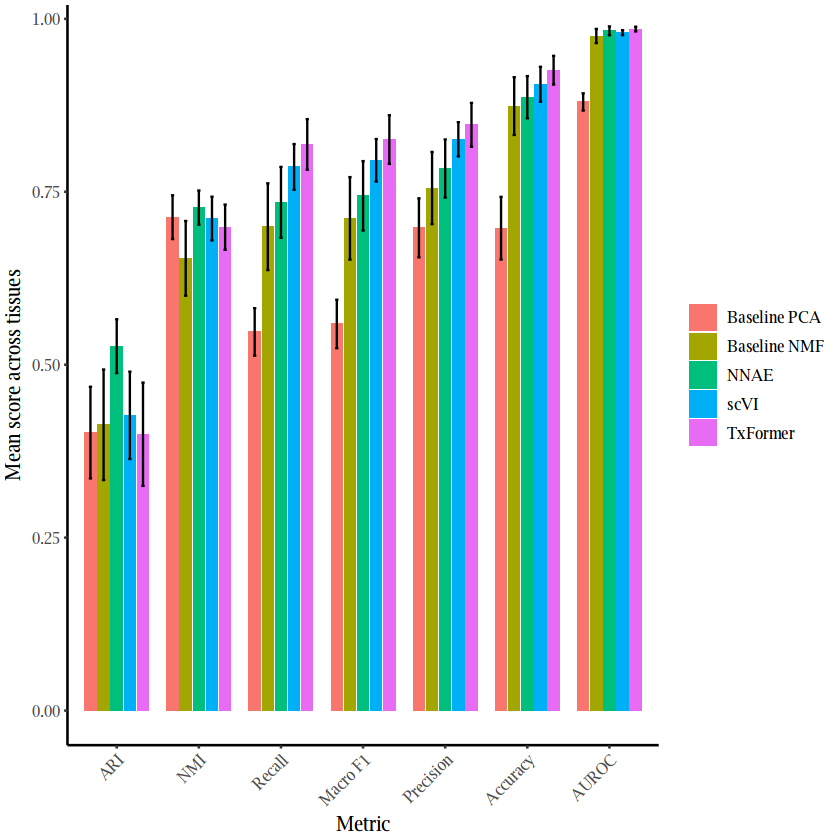

In [5]:
#=========================================================
# TSv2 summary plot
#=========================================================

library(dplyr)
library(tidyr)

# ---------- Long format for clustering (ARI, NMI) ----------
cluster_long <- bench_plot %>%
  select(Method, Tissue, ARI, NMI) %>%
  pivot_longer(
    cols      = c(ARI, NMI),
    names_to  = "Metric",
    values_to = "Score"
  )

# ---------- Long format for cell-type classification metrics ----------
cls_long <- cls_plot %>%
  select(Method, Tissue, `Macro F1`, Accuracy, Precision, Recall, AUROC) %>%
  pivot_longer(
    cols      = c(`Macro F1`, Accuracy, Precision, Recall, AUROC),
    names_to  = "Metric",
    values_to = "Score"
  )

# ---------- Combine & compute mean + SE across tissues ----------
full_long <- bind_rows(cluster_long, cls_long)

full_summary <- full_long %>%
  group_by(Method, Metric) %>%
  summarise(
    mean_score = mean(Score, na.rm = TRUE),
    sd_score   = sd(Score,   na.rm = TRUE),
    n_tissue   = sum(!is.na(Score)),
    se_score   = sd_score / sqrt(pmax(1, n_tissue)),
    .groups    = "drop"
  ) %>%
  mutate(
    Metric = factor(
      Metric,
      levels = c("ARI", "NMI", "Recall", "Macro F1", "Precision", "Accuracy", "AUROC")
    )
  )

# Panel A

methods_A <- c("Baseline PCA", "Baseline NMF", "NNAE", "scVI", "TxFormer")

summary_A <- full_summary %>%
  filter(Method %in% methods_A) %>%
  mutate(Method = droplevels(Method))

pos_dodge_metrics <- position_dodge(width = 0.8)

p_bench_A <- ggplot(summary_A,
                    aes(x = Metric, y = mean_score, fill = Method)) +
  geom_col(position = pos_dodge_metrics, width = 0.7) +
  geom_errorbar(
    aes(
      ymin = pmax(0, mean_score - se_score),
      ymax = pmin(1, mean_score + se_score)
    ),
    position = pos_dodge_metrics,
    width = 0.2
  ) +
  scale_y_continuous(
    limits = c(0, 1),
    expand = expansion(mult = c(0.05, 0.02))
  ) +
  labs(
    x = "Metric",
    y = "Mean score across tissues"
  ) +
  plt_theme +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "right"
  )

save_pdf(file.path(fig_dir, "tsv2_bench_panelA_all_metrics.pdf"),
         p_bench_A, w = 6, h = 4)
print(p_bench_A)


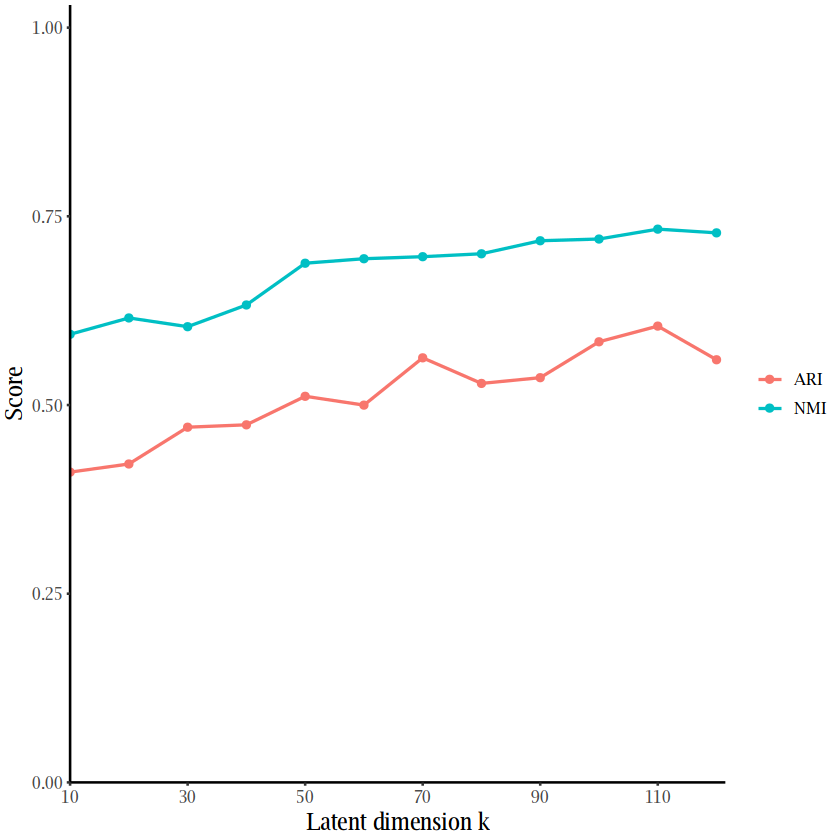

In [9]:
#!/usr/bin/env Rscript

suppressPackageStartupMessages({
  library(readr)
  library(dplyr)
  library(ggplot2)
})

# ---------------- helper theme ----------------
if (!exists("plt_theme")) {
  plt_theme <- theme_classic()
}

# ---------------- load multi-rank ARI / NMI ----------------
ari_path <- file.path(fig_dir, "ARI_values_three_metrics.csv")
nmi_path <- file.path(fig_dir, "NMI_values_three_metrics.csv")

ari_raw <- readr::read_csv(ari_path, show_col_types = FALSE)
nmi_raw <- readr::read_csv(nmi_path, show_col_types = FALSE)

# ---------------- NNAE only (HW) -> long format ----------------
ari_long <- ari_raw %>%
  dplyr::select(k, ARI_HW) %>%
  dplyr::transmute(
    k,
    Metric = "ARI",
    mean   = ARI_HW
  )

nmi_long <- nmi_raw %>%
  dplyr::select(k, NMI_HW) %>%
  dplyr::transmute(
    k,
    Metric = "NMI",
    mean   = NMI_HW
  )

df_plot <- dplyr::bind_rows(ari_long, nmi_long) %>%
  dplyr::mutate(Metric = factor(Metric, levels = c("ARI", "NMI")))

# ---------------- one plot: NNAE ARI + NNAE NMI ----------------
p_nnae_ari_nmi <- ggplot(df_plot, aes(x = k, y = mean, color = Metric, group = Metric)) +
  geom_line(linewidth = 0.7) +
  geom_point(shape = 16, size = 2) +
  scale_x_continuous(
    breaks = seq(min(df_plot$k), max(df_plot$k), by = 20),
    expand = expansion(mult = c(0, 0), add = c(0, 1.5))
  ) +
  scale_y_continuous(
    limits = c(0, 1),
    expand = expansion(mult = c(0, 0), add = c(0, 0.03))
  ) +
  labs(
    x = "Latent dimension k",
    y = "Score",
    color = NULL
  ) +
  plt_theme +
  theme(
    legend.position  = "right",
    axis.title.x     = element_text(family = "serif", size = 14),
    axis.title.y     = element_text(family = "serif", size = 14),
    axis.text.x      = element_text(family = "serif", size = 10),
    axis.text.y      = element_text(family = "serif", size = 10),
    panel.border     = element_blank()
  )

print(p_nnae_ari_nmi)

# ---------------- save ----------------
if (exists("save_pdf")) {
  save_pdf(
    file.path(fig_dir, "nnae_multirank_ARI_NMI.pdf"),
    p_nnae_ari_nmi,
    w = 4.0,
    h = 3.5
  )
}

ggplot2::ggsave(
  file.path(fig_dir, "nnae_multirank_ARI_NMI.png"),
  p_nnae_ari_nmi,
  width  = 4.0,
  height = 3.5,
  units  = "in",
  dpi    = 300,
  bg     = "white"
)



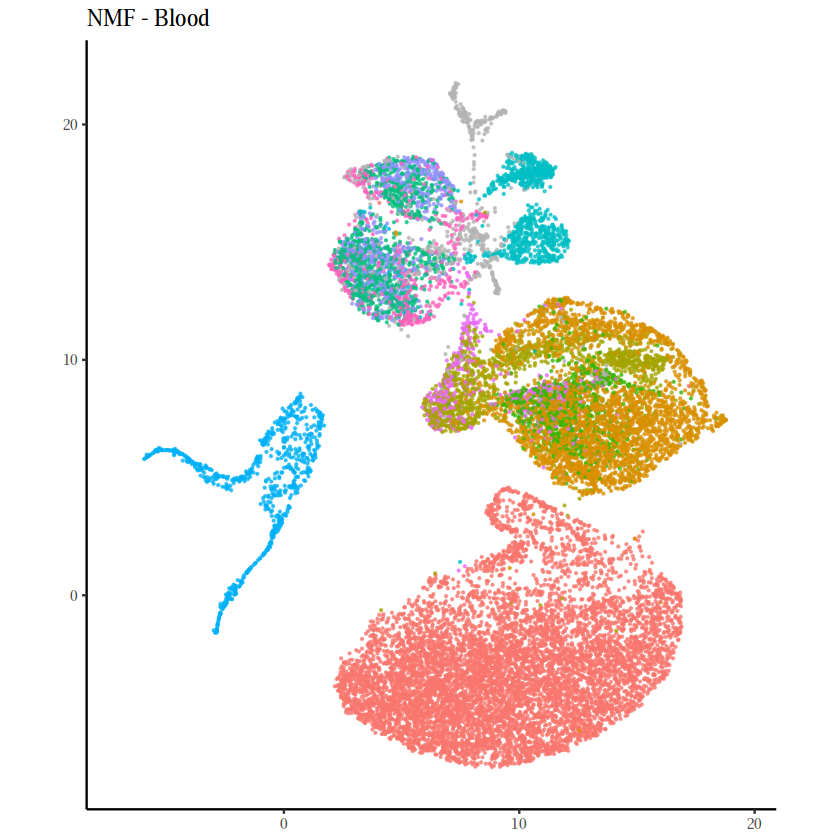

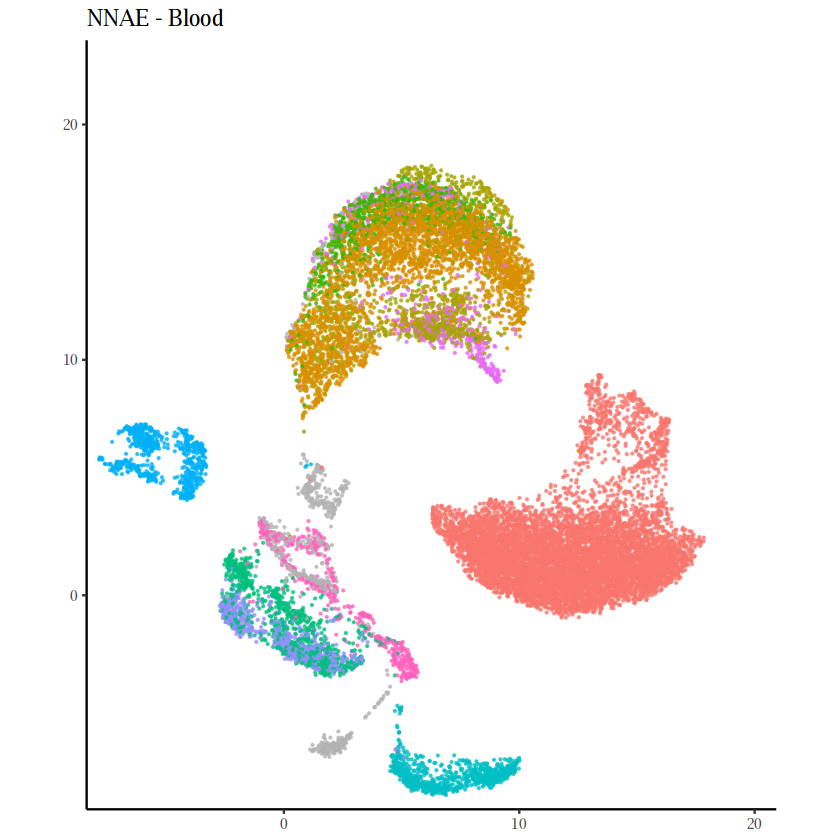

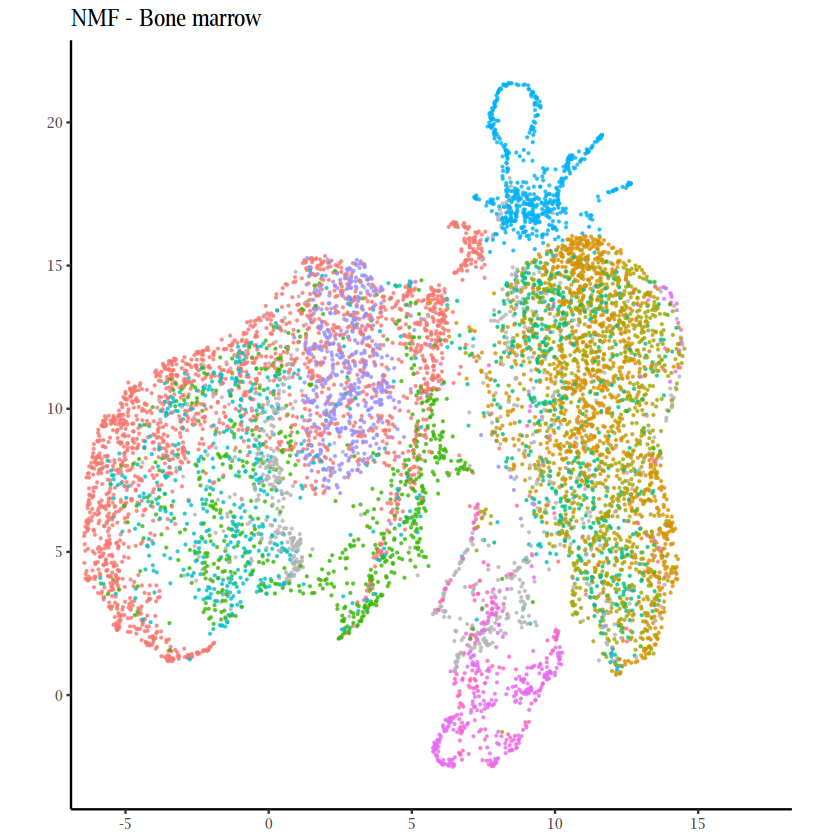

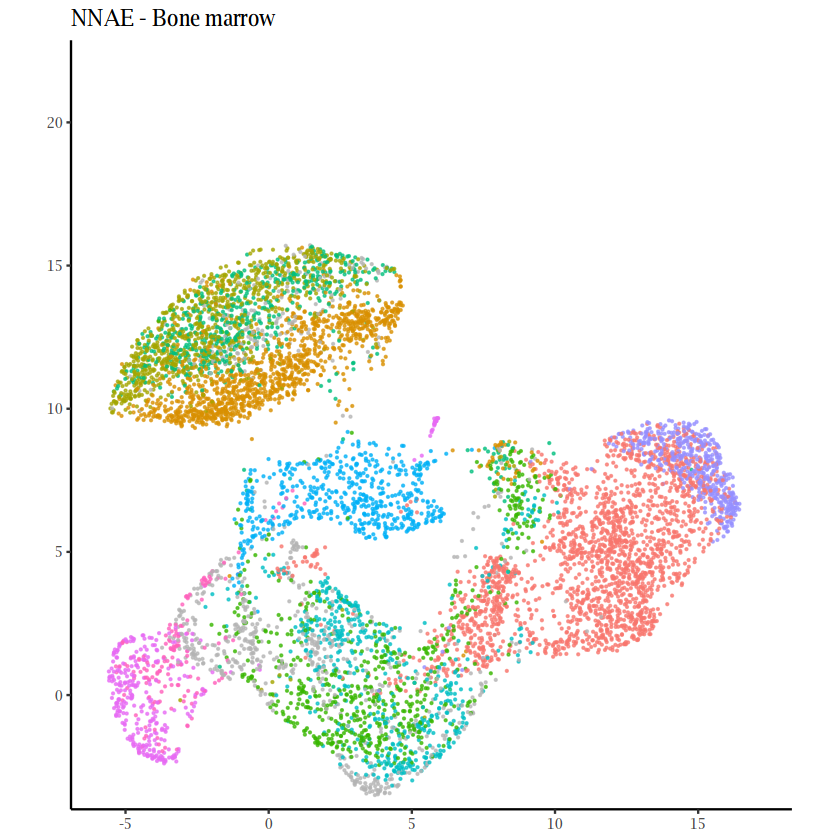

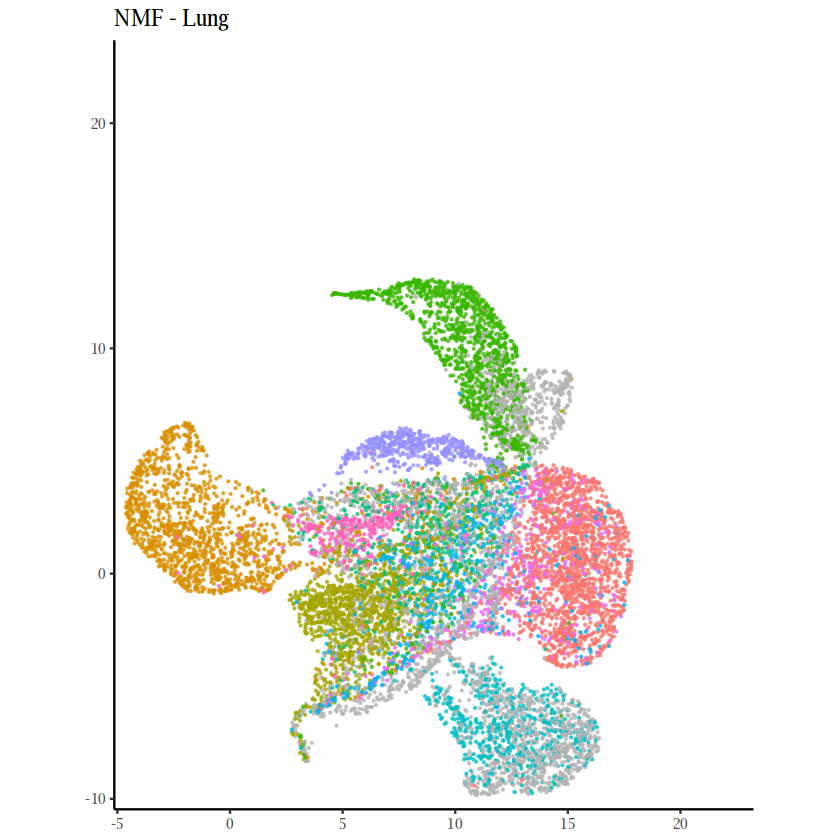

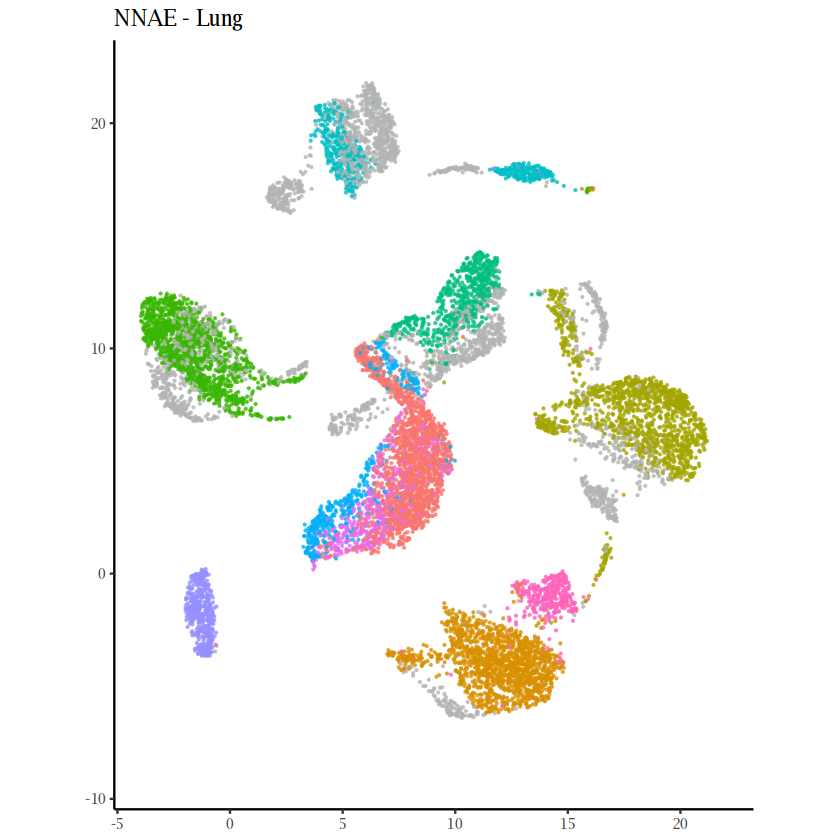

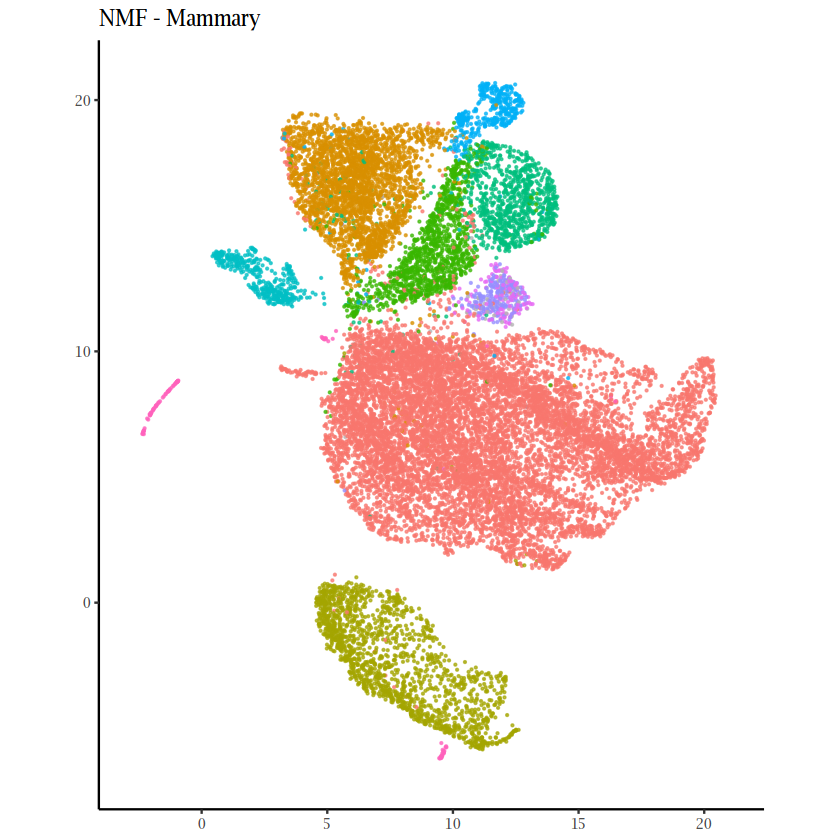

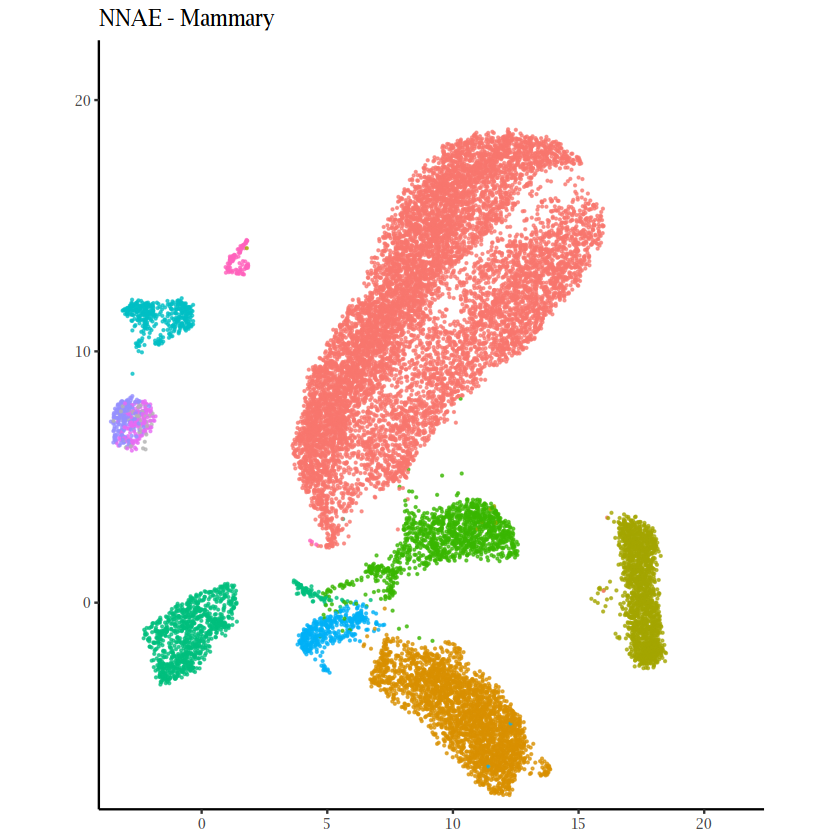

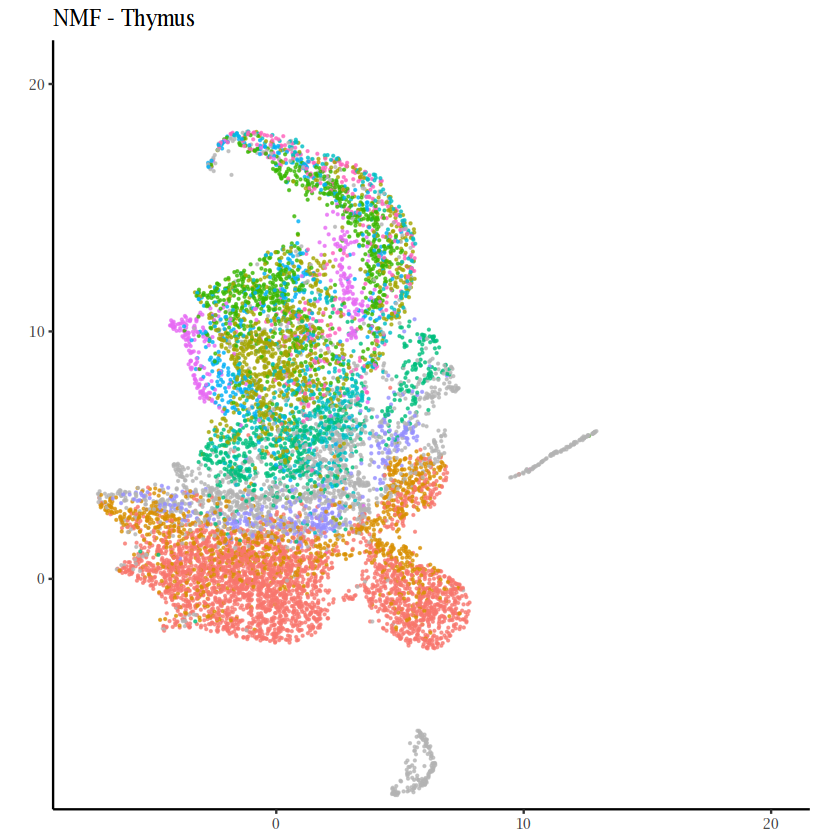

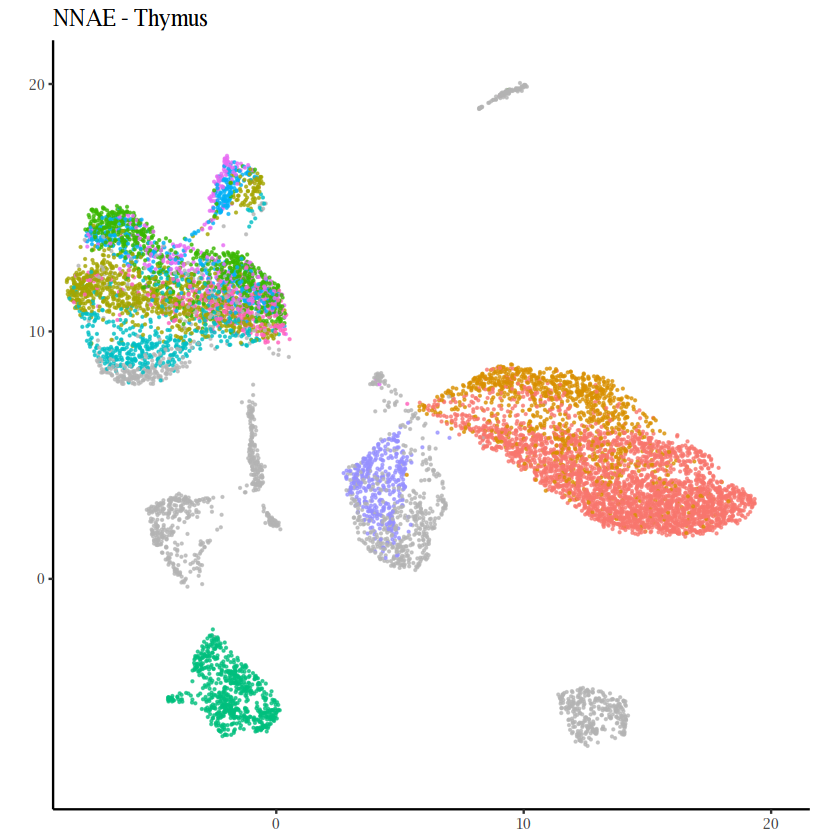

In [18]:
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(scales)

# ============================================================
# TSv2 UMAP plots for ALL tissues (NMF + NNAE), colored by cell type
# (titles use pretty tissue names, e.g., Bone marrow)
# ============================================================

dir <- "/mnt/projects/debruinz_project/bisholea/capstone/tsv2_benchmarks/umap_exports"
tissues <- c("Blood", "Bone_Marrow", "Lung", "Mammary", "Thymus")

# ---- pretty tissue labels (USED FOR TITLES) ----
tissue_labels <- c(
  Blood       = "Blood",
  Bone_Marrow = "Bone marrow",
  Lung        = "Lung",
  Mammary     = "Mammary",
  Thymus      = "Thymus"
)

# ---- styling helpers ----
base_theme <- theme_classic() +
  theme(
    legend.position = "none",
    text = element_text(family = "serif")
  )

trunc_12 <- function(x, n = 12) {
  x <- as.character(x)
  ifelse(nchar(x) > n, paste0(substr(x, 1, n), "..."), x)
}

pad_scale <- list(
  scale_x_continuous(expand = expansion(mult = c(0.02, 0.08))),
  scale_y_continuous(expand = expansion(mult = c(0.02, 0.06)))
)

plots <- list()

for (tissue in tissues) {

  # --- use pretty tissue name in titles ---
  pretty_tissue <- tissue_labels[[tissue]]
  if (is.null(pretty_tissue)) pretty_tissue <- gsub("_", " ", tissue)

  nmf_path  <- file.path(dir, paste0("tsv2_umap_", tissue, "_NMF_celltype.csv"))
  nnae_path <- file.path(dir, paste0("tsv2_umap_", tissue, "_NNAE_celltype.csv"))

  if (!file.exists(nmf_path)) {
    warning("Missing NMF file, skipping: ", nmf_path)
    next
  }
  if (!file.exists(nnae_path)) {
    warning("Missing NNAE file, skipping: ", nnae_path)
    next
  }

  df_nmf  <- read_csv(nmf_path,  show_col_types = FALSE)
  df_nnae <- read_csv(nnae_path, show_col_types = FALSE)

  # ------------------------------------------------------------
  # Top-10 cell types across BOTH datasets; rest -> "Other"
  # ------------------------------------------------------------
  top_n <- 10
  top10 <- bind_rows(df_nmf, df_nnae) %>%
    count(cell_type, sort = TRUE) %>%
    slice_head(n = top_n) %>%
    pull(cell_type)

  df_nmf <- df_nmf %>%
    mutate(cell_type_top10 = if_else(cell_type %in% top10, cell_type, "Other"))

  df_nnae <- df_nnae %>%
    mutate(cell_type_top10 = if_else(cell_type %in% top10, cell_type, "Other"))

  lvl <- c(top10, "Other")
  df_nmf$cell_type_top10  <- factor(df_nmf$cell_type_top10,  levels = lvl)
  df_nnae$cell_type_top10 <- factor(df_nnae$cell_type_top10, levels = lvl)

  # ------------------------------------------------------------
  # Shared axis limits (within tissue)
  # ------------------------------------------------------------
  x_rng <- range(c(df_nmf$umap_1, df_nnae$umap_1), na.rm = TRUE)
  y_rng <- range(c(df_nmf$umap_2, df_nnae$umap_2), na.rm = TRUE)

  # ------------------------------------------------------------
  # Color mapping
  # ------------------------------------------------------------
  default_cols <- scales::hue_pal()(length(top10))
  pal <- setNames(c(default_cols, "gray70"), c(top10, "Other"))

  # ------------------------------------------------------------
  # Build plots (TITLE FIX IS HERE)
  # ------------------------------------------------------------
  p_nmf <- ggplot(df_nmf, aes(umap_1, umap_2, color = cell_type_top10)) +
    geom_point(size = 0.15, alpha = 0.7) +
    scale_color_manual(
      values = pal,
      drop   = FALSE,
      labels = trunc_12,
      guide  = guide_legend(override.aes = list(size = 2.0, alpha = 1))
    ) +
    coord_equal(xlim = x_rng, ylim = y_rng) +
    base_theme +
    labs(title = paste0("NMF - ", pretty_tissue), x = NULL, y = NULL) +
    pad_scale

  p_nnae <- ggplot(df_nnae, aes(umap_1, umap_2, color = cell_type_top10)) +
    geom_point(size = 0.15, alpha = 0.7) +
    scale_color_manual(
      values = pal,
      drop   = FALSE,
      labels = trunc_12,
      guide  = guide_legend(override.aes = list(size = 2.0, alpha = 1))
    ) +
    coord_equal(xlim = x_rng, ylim = y_rng) +
    base_theme +
    labs(title = paste0("NNAE - ", pretty_tissue), x = NULL, y = NULL) +
    pad_scale

  plots[[paste0(tissue, "_NMF")]]  <- p_nmf
  plots[[paste0(tissue, "_NNAE")]] <- p_nnae
}

# ============================================================
# Print ALL plots (tissue-by-tissue: NMF then NNAE)
# ============================================================
for (tissue in tissues) {
  key_nmf  <- paste0(tissue, "_NMF")
  key_nnae <- paste0(tissue, "_NNAE")

  if (key_nmf %in% names(plots))  print(plots[[key_nmf]])
  if (key_nnae %in% names(plots)) print(plots[[key_nnae]])
}



Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”
Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”
Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”
Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”
Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


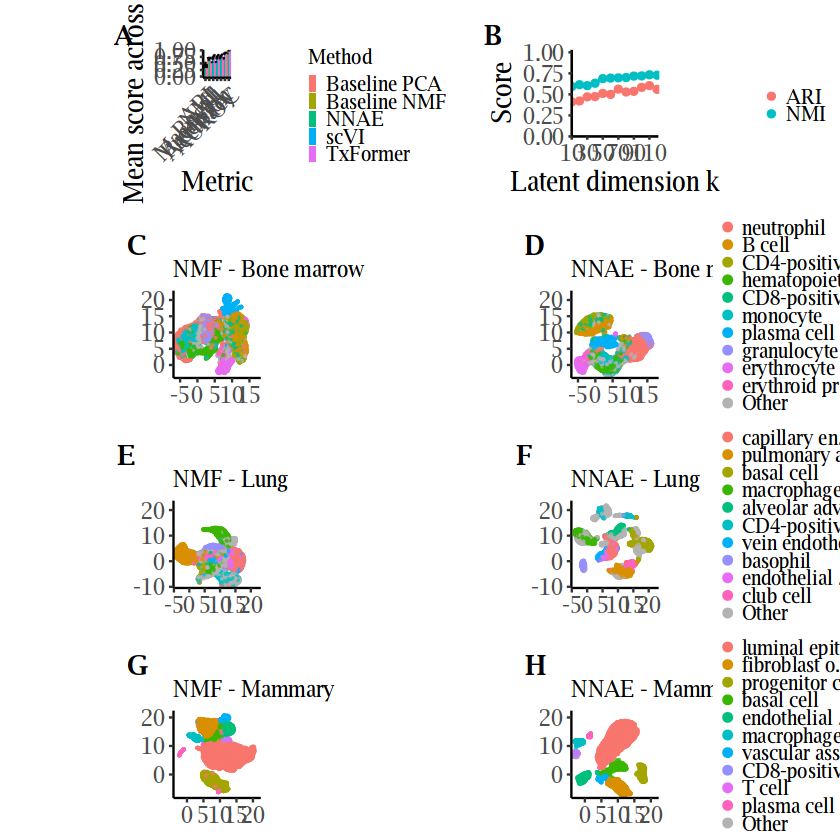

In [23]:
library(cowplot)
library(ggplot2)
library(grid)

# ==========================================================
# Figure: 4x2 panel with per-row UMAP legends
# ==========================================================

# -----------------------------
# 0) Fail early if missing
# -----------------------------
stopifnot(exists("p_bench_A"))
stopifnot(exists("p_nnae_ari_nmi"))
stopifnot(exists("plots"))
stopifnot(all(c("Bone_Marrow_NMF","Bone_Marrow_NNAE",
                "Lung_NMF","Lung_NNAE",
                "Mammary_NMF","Mammary_NNAE") %in% names(plots)))

# -----------------------------
# 1) Pull UMAP plots out of list
# -----------------------------
p_bm_nmf    <- plots[["Bone_Marrow_NMF"]]
p_bm_nnae   <- plots[["Bone_Marrow_NNAE"]]
p_lung_nmf  <- plots[["Lung_NMF"]]
p_lung_nnae <- plots[["Lung_NNAE"]]
p_mam_nmf   <- plots[["Mammary_NMF"]]
p_mam_nnae  <- plots[["Mammary_NNAE"]]

# =========================
# 2) Extract legends (A, B, and UMAP legends PER tissue)
# =========================
leg_A <- get_legend(
  p_bench_A +
    theme(
      legend.position  = "right",
      text             = element_text(family = "serif", size = 12),
      legend.title     = element_text(family = "serif", size = 12),
      legend.text      = element_text(family = "serif", size = 12),
      legend.key.size  = grid::unit(0.35, "lines"),
      legend.spacing.y = grid::unit(0.15, "lines"),
      legend.box.margin= margin(0, 0, 0, 0)
    )
)

leg_B <- get_legend(
  p_nnae_ari_nmi +
    theme(
      legend.position  = "right",
      text             = element_text(family = "serif", size = 12),
      legend.title     = element_text(family = "serif", size = 12),
      legend.text      = element_text(family = "serif", size = 12),
      legend.key.size  = grid::unit(0.35, "lines"),
      legend.spacing.y = grid::unit(0.15, "lines"),
      legend.box.margin= margin(0, 0, 0, 0)
    )
)

# Helper: force legend ON just for extracting it
extract_umap_legend <- function(p) {
  get_legend(
    p +
      labs(color = NULL) +
      theme(
        legend.position = "right",
        legend.title    = element_blank(),
        text            = element_text(family = "serif", size = 12),
        legend.text     = element_text(family = "serif", size = 12),
        legend.key.size = grid::unit(0.35, "lines"),
        legend.spacing.y= grid::unit(0.15, "lines"),
        legend.box.margin = margin(0, 0, 0, 0)
      )
  )
}

leg_umap_bm   <- extract_umap_legend(p_bm_nmf)
leg_umap_lung <- extract_umap_legend(p_lung_nmf)
leg_umap_mam  <- extract_umap_legend(p_mam_nmf)

# =========================
# 3) Legend-free versions + tags
# =========================
fig5_tag_theme <- theme(
  legend.position = "none",
  axis.title.x = element_text(family = "serif", size = 16),
  axis.title.y = element_text(family = "serif", size = 16),
  axis.text.x  = element_text(family = "serif", size = 14),
  axis.text.y  = element_text(family = "serif", size = 14),
  plot.tag = element_text(family = "serif", face = "bold", size = 16),
  plot.tag.position = c(0.01, 1.1),
  plot.title  = element_text(hjust = 0),
  plot.margin = margin(t = 30, r = 6, b = 8, l = 6)
)

square_panel <- theme(aspect.ratio = 1)
sp <- ggplot() + theme_void()

# Row 1
pA_tag <- p_bench_A      + fig5_tag_theme + square_panel + labs(tag = "A")
pB_tag <- p_nnae_ari_nmi + fig5_tag_theme + square_panel + labs(tag = "B")

# Row 2 (Bone Marrow)
pC_tag <- p_bm_nmf  + fig5_tag_theme + square_panel + labs(tag = "C") +
  theme(plot.tag.position = c(-0.04, 1.1))
pD_tag <- p_bm_nnae + fig5_tag_theme + square_panel + labs(tag = "D") +
  theme(plot.tag.position = c(-0.04, 1.1))

# Row 3 (Lung)
pE_tag <- p_lung_nmf  + fig5_tag_theme + square_panel + labs(tag = "E") +
  theme(plot.tag.position = c(-0.02, 1.1))
pF_tag <- p_lung_nnae + fig5_tag_theme + square_panel + labs(tag = "F") +
  theme(plot.tag.position = c(-0.02, 1.1))

# Row 4 (Mammary)
pG_tag <- p_mam_nmf  + fig5_tag_theme + square_panel + labs(tag = "G") +
  theme(plot.tag.position = c(-0.04, 1.1))
pH_tag <- p_mam_nnae + fig5_tag_theme + square_panel + labs(tag = "H") +
  theme(plot.tag.position = c(-0.04, 1.1))

# =========================
# 4) Align columns
# =========================
aligned_left  <- align_plots(pA_tag, pC_tag, pE_tag, pG_tag, align = "v", axis = "l")
pA_al <- aligned_left[[1]]
pC_al <- aligned_left[[2]]
pE_al <- aligned_left[[3]]
pG_al <- aligned_left[[4]]

aligned_right <- align_plots(pB_tag, pD_tag, pF_tag, pH_tag, align = "v", axis = "l")
pB_al <- aligned_right[[1]]
pD_al <- aligned_right[[2]]
pF_al <- aligned_right[[3]]
pH_al <- aligned_right[[4]]

# align bottom x-axes across each UMAP row pair
pair_CD <- align_plots(pC_al, pD_al, align = "h", axis = "b")
pC_al2 <- pair_CD[[1]]; pD_al2 <- pair_CD[[2]]

pair_EF <- align_plots(pE_al, pF_al, align = "h", axis = "b")
pE_al2 <- pair_EF[[1]]; pF_al2 <- pair_EF[[2]]

pair_GH <- align_plots(pG_al, pH_al, align = "h", axis = "b")
pG_al2 <- pair_GH[[1]]; pH_al2 <- pair_GH[[2]]

# =========================
# 5) Rows layout (legend per UMAP row)
# =========================
row1 <- plot_grid(
  pA_al, leg_A,
  pB_al, leg_B,
  nrow = 1,
  rel_widths = c(4, 0.5, 4, 1)
)

row2 <- plot_grid(
  pC_al2, sp,
  pD_al2, leg_umap_bm,
  nrow = 1,
  rel_widths = c(4, 0.5, 4, 1)
)

row3 <- plot_grid(
  pE_al2, sp,
  pF_al2, leg_umap_lung,
  nrow = 1,
  rel_widths = c(4, 0.5, 4, 1)
)

row4 <- plot_grid(
  pG_al2, sp,
  pH_al2, leg_umap_mam,
  nrow = 1,
  rel_widths = c(4, 0.5, 4, 1)
)

fig5 <- plot_grid(
  row1, row2, row3, row4,
  ncol = 1,
  rel_heights = c(1, 1, 1, 1)
)

print(fig5)

# =========================
# 6) Save
# =========================
panel_h <- 3.5

ggsave(
  file.path(fig_dir, "figure5_panel.pdf"),
  fig5,
  width  = 9,
  height = 4 * panel_h,
  units  = "in",
  bg     = "white"
)

ggsave(
  file.path(fig_dir, "figure5_panel.png"),
  fig5,
  width  = 9,
  height = 4 * panel_h,
  units  = "in",
  dpi    = 300,
  bg     = "white"
)
